# Preliminary data analysis

Here we deal with the preliminary data analysis of the graph, Reddit data as well as event series.

### 1) Import packages

In [2]:
import os
from pathlib import Path
import json
import bz2

from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel, shapiro, wilcoxon

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter, OrderedDict

import networkx as nx
from networkx.readwrite import json_graph
import netwulf as nw

import plotly.express as px


In [3]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [4]:
DATA_DIR = Path(os.getcwd()) / 'data'

### 2) Climate Change Opinion classifier

The classifier was a RandomForest classifier trained on the annotated Twitter data (as described in the explainer notebook) and optimized with randomized search and cross-validation for 500 different parameter combinations within the parameter grid described below.

```
parameters = {'clf__n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000],
               'clf__max_features': ['sqrt', 'auto'],
               'clf__max_depth': [90, 100, 110, 120, 130, 140],
               'clf__min_samples_split': [2, 4, 6, 8, 10],
               'clf__min_samples_leaf': [1, 2, 3, 4],
               'clf__bootstrap': [False, True]}
```

All steps containing a stochastic element were carried out using `random_state=42`. 

The Climate Change opinion classifier training step is implemented in the file `exploration/opinion_classifier.py`. This section describes the training of the classifier and evaluates its performance. First, data was loaded.

In [14]:
filename = 'twitter_sentiment_data.csv'
tweets = pd.read_csv(DATA_DIR/filename)

# map opinion label
class_mapping = {2: 'News',
                 1: 'Pro',
                 0: 'Neutral',
                 -1: 'Anti'}

tweets['label'] = tweets['sentiment'].progress_apply(lambda x: class_mapping[x])

tweets.head()

  0%|          | 0/43943 [00:00<?, ?it/s]

,sentiment,message,tweetid,label
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,Anti
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,Pro
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,Pro
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,Pro
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,News


In [15]:
print(f"Number of data points: {tweets.__len__()}")

Number of data points: 43943


Before training the classifier it is important to investigate the label distribution. This can be seen in the following pie chart, created in the file `exploration/opinion_classifier.ipynb`.

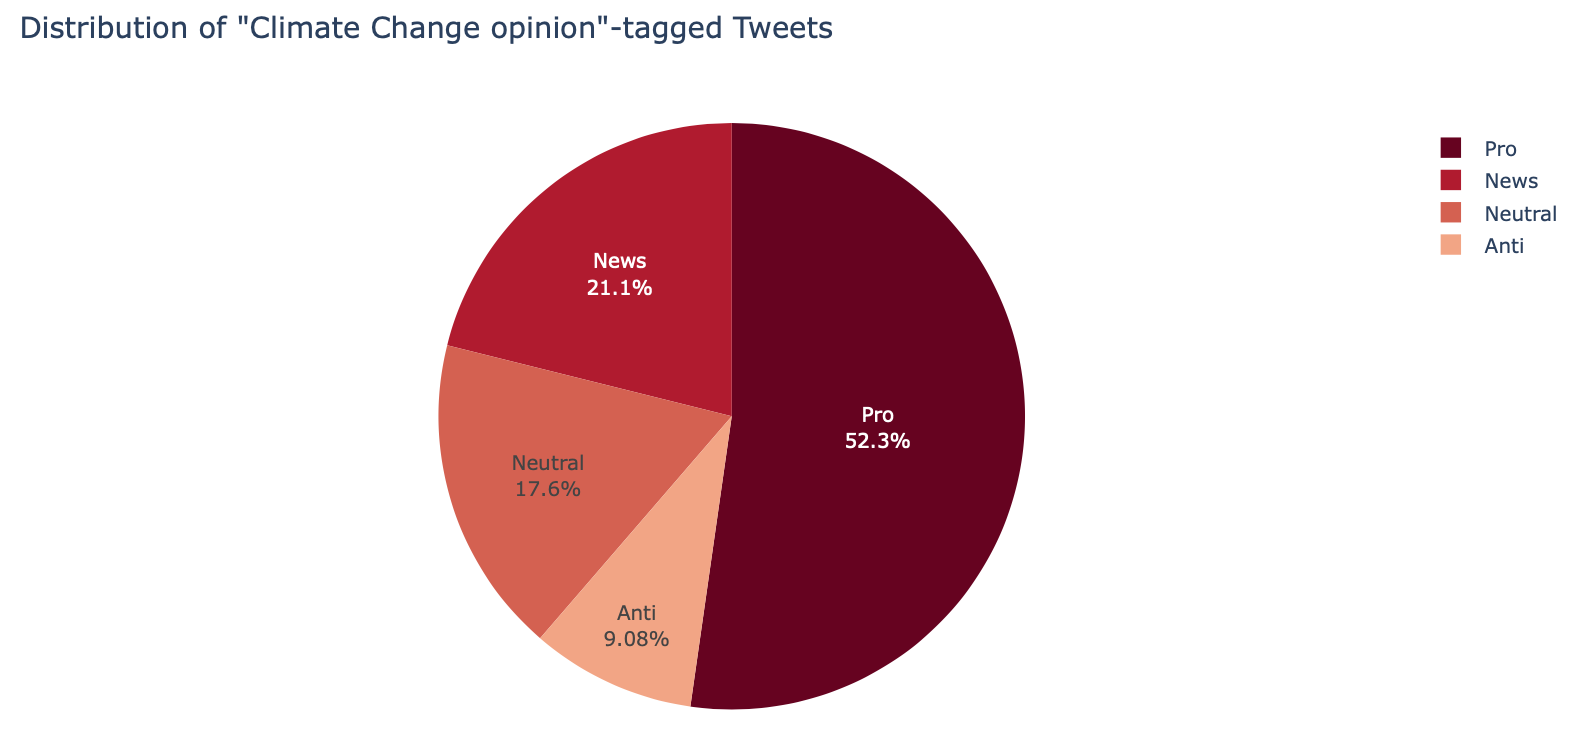

Here, it is evident that the 'Pro' class is the largest one that is approximately 6 times larger than the smallest class, 'Anti'. In order to not train a biased model, we decided to downsample all classes to the size of the smallest class, 'Anti'.

In [16]:
# define smallest group
smallest_group = tweets[tweets['label'] == 'Anti']
smallest_group_size = smallest_group.__len__()

# downsample each class to the size of the smallest group
temp = [smallest_group]
for label in class_mapping.values():
    if label != 'Anti':
        temp.append(tweets[tweets['label'] == label].sample(smallest_group_size, random_state=42))
        
# create balanced dataset
tweets_balanced = pd.concat(temp)

# shuffle and reindex the data
tweets_balanced = tweets_balanced.sample(frac=1, random_state=42)
tweets_balanced = tweets_balanced.reset_index().drop('index', axis=1)
tweets_balanced.head()

,sentiment,message,tweetid,label
0,-1,"RT @TheMarkRomano: Remember, we're supposed be...",857188789726433281,Anti
1,2,RT @RiceRPLP: Religion plays a bigger role in ...,809918715999289344,News
2,2,Climate change is a major global challenge: PM...,671369836635758593,News
3,1,RT @DrJillStein: Trump pretends not to believe...,793490890102714369,Pro
4,0,I love when republicans talk about climate change,644342836389810176,Neutral


Next, the tweets were processed using the standard pre-processing pipeline, meaning that the text was tokenized into words, lower-cased after which stop-words and non-alphabetical characters were excluded. Furthermore, stemming was applied and the Twitter-specific token "RT" was removed since the classifier later on should be used for predicting opinion scores on Reddit data.

In [20]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

# load stop-words
stop_words = set(stopwords.words('english'))

# add webpages to stopwords
stop_words.add('http') 
stop_words.add('https')

porter = PorterStemmer()

exclusions = {'RT'}

# define tokenizing function
clean = lambda x: set([porter.stem(word_token).lower() for word_token in word_tokenize(x) \
                       if word_token.lower() not in stop_words \
                       and word_token.isalpha() \
                       and word_token not in exclusions])

# apply tokenizing to texts - progress_apply for seeing progress bar WHEN running
tokens = tweets_balanced['message'].progress_apply(lambda text: clean(text))
tweets_balanced['tokens'] = tokens

  0%|          | 0/15960 [00:00<?, ?it/s]

The processing created a token-representation for a text. These were once again concatenated, to fit in line with the classifier training step. A training size of 70% of the total data was chosen.

The actual classifier was implemented using the sklearn `Pipeline` method where a Twitter text was mapped to a Bag-of-Word representation (using `CountVectorizer`) after which TF-IDF scores were computed (using `TfidfTransformer`) and fed to the `RandomForestClassifier`. This is seen here:

```
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(criterion='gini', random_state=42))
])
```

In [27]:
from sklearn.model_selection import train_test_split

tweets_balanced['processed_message'] = tweets_balanced['tokens'].progress_apply(lambda x: (" ").join(x))
tweets_balanced['processed_message'].to_numpy()

X = tweets_balanced['processed_message'].to_numpy()
y = tweets_balanced['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  0%|          | 0/15960 [00:00<?, ?it/s]

The training procedure was carried out on DTU GBAR due for computational reasons. The final model was pickled and is now loaded and evaluated.

In [ ]:
pkl_filename = Path(os.getcwd()).parent / 'model/RandomForest_TwitterOpinion_500iter.pkl'

with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

In [ ]:
predicted = model.predict(X_test)
print("Accuracy on Test Data: ", np.mean(predicted == y_test))

In [ ]:
label_order = np.array(list(class_mapping.values()))
cm = confusion_matrix(y_test, predicted, labels=label_order)

plt.figure(figsize=((12,8)))
sns.heatmap(cm, annot=True, fmt='g', linewidths=3, cmap='Blues', square=True, xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

In [ ]:
label_order = np.array(list(class_mapping.values()))
cm = confusion_matrix(y_test, predicted, labels=label_order, normalize='true')

plt.figure(figsize=((12,8)))
sns.heatmap(cm, annot=True, fmt='.3g', linewidths=3, cmap='Blues', square=True, xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
print(balanced_accuracy_score(y_test, predicted))

In [ ]:
print(classification_report(y_test, predicted, digits=3))

### 3) Reddit submission and comments

In [3]:
# TODO:

In [4]:
submissions.__len__() - filtered_submissions.__len__()

NameError: name 'submissions' is not defined

In [ ]:
submissions.shape

In [ ]:
comments.shape

In [ ]:
comments.__len__() - filtered_comments.__len__()

### 4) ClimateGraph

We start by loading the Reddit-ClimateGraph for the year 2020.

In [4]:
year = 2020
ClimateGraph = read_json_file(DATA_DIR / f'{year}/ClimateGraph_{year}.json')

Let's investigate some basic properties of the network, such as the size.

In [5]:
print(f"Number of nodes: {ClimateGraph.number_of_nodes()}")
print(f"Number of edges: {ClimateGraph.number_of_edges()}")

Number of nodes: 64260
Number of edges: 95736


As is seen in the figures below, the degree-distributions of this network is following a power law, meaning that many Reddit authors have low in- and out-reach, yet a small minority of the Reddit authors have respectively high in- and out-reach.

In [6]:
in_degree = pd.Series(np.array(list(zip(*ClimateGraph.in_degree())))[1].astype('int'))
out_degree = pd.Series(np.array(list(zip(*ClimateGraph.out_degree())))[1].astype('int'))
degree = pd.Series(np.array(list(zip(*ClimateGraph.degree())))[1].astype('int'))

df_degrees = pd.DataFrame([in_degree, out_degree, degree], index=['in-degree', 'out-degree', 'degree']).T
df_degrees.describe()

,in-degree,out-degree,degree
count,64260.000000,64260.000000,64260.000000
mean,1.489823,1.489823,2.979645
std,7.764975,3.350204,9.260341
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,1.000000,1.000000,3.000000
max,732.000000,604.000000,732.000000


In [7]:
# define plotting function
def LogAndLinearHist(data, xlabel='', figsize=((8,3)), dpi=100):
    min_val, max_val = (min(data), max(data))
    
    # compute bins
    log_bins = np.logspace(min_val if min_val == 0 else np.log10(min_val), np.log10(max_val), 101)
    lin_bins = np.linspace(min_val, max_val, 101)

    # create histogram values
    hist_log, edges_log = np.histogram(data.values, log_bins, density=True)
    hist_lin, edges_lin = np.histogram(data.values, lin_bins)

    # determine x-values
    log_x = (edges_log[1:] + edges_log[:-1]) / 2.
    lin_x = (edges_lin[1:] + edges_lin[:-1]) / 2.

    xx, yy = zip(*[(i,j) for (i,j) in zip(log_x, hist_log) if j > 0])
    
    # plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # linear scale plot
    ax[0].plot(lin_x, hist_lin, marker='.', alpha=0.5)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('count')
    ax[0].set_title('linear scale')
    #ax[0].legend()

    # log-log scale plot
    ax[1].plot(xx, yy, marker='.', alpha=0.5)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('probability density')
    ax[1].set_title('log-log scale')
    #ax[1].legend()

    # show figure
    plt.tight_layout()
    plt.show()

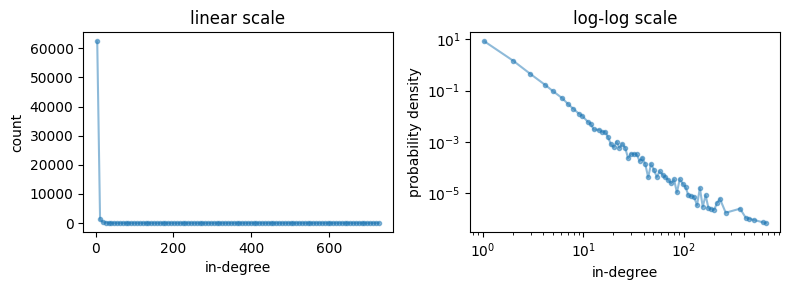

In [8]:
LogAndLinearHist(in_degree, xlabel='in-degree')

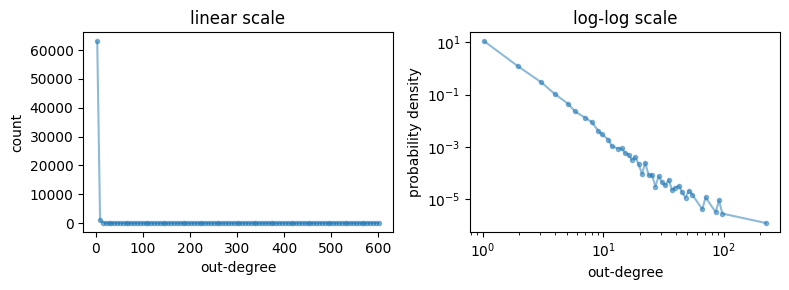

In [9]:
LogAndLinearHist(out_degree, xlabel='out-degree')

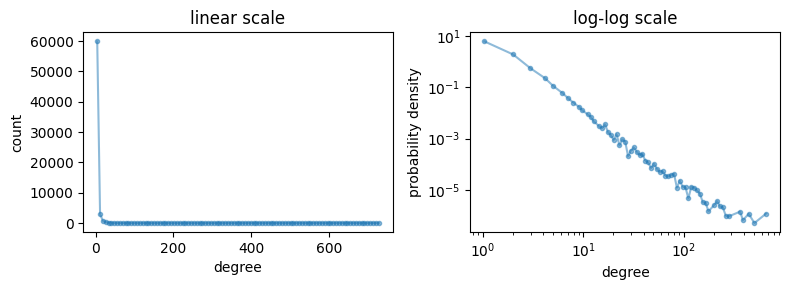

In [10]:
LogAndLinearHist(degree, xlabel='degree')

The power law distribution means that there, e.g., is only 98 Reddit authors that are referrenced to by more than 50 other Reddit authors.

In [58]:
print(f"Number of authors with in-degree above 50: {(in_degree > 50).sum()}")

Number of authors with in-degree above 50: 98


One of the key properties of the ClimateGraph is the associated opinion score. This score is individual for each author and was created as the average opinion across their respective comments and submissions to climate change within the year. This score distribution is key for decision-making related to the research questions.

The distribution of opinion scores is visualized in the plots below.

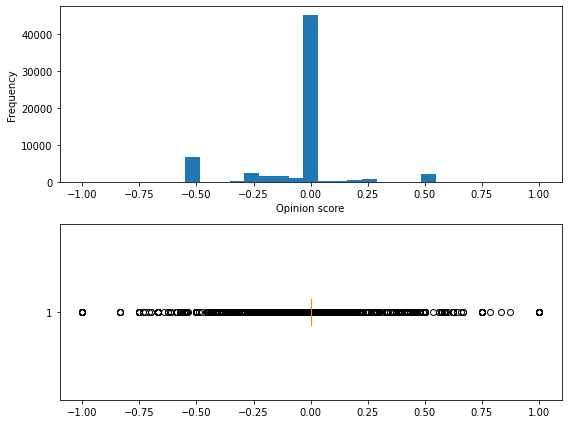

In [11]:
opinion_distribution = pd.Series(nx.get_node_attributes(ClimateGraph, 'opinion_score').values())

plt.figure(figsize=((8,6)))
ax1 = plt.subplot(211)
opinion_distribution.plot(kind='hist', bins=31)
plt.xlabel('Opinion score')

plt.subplot(212, sharex=ax1)
plt.boxplot(opinion_distribution, vert=False)

plt.tight_layout()
plt.show()

As can be seen in the figures and in the list of descriptive statistics below, the full range of the opinion score (which is between -1 and 1) is exploited, yet, the majority of authors end up with an opinion score close to 1, which originates from textual content about either News or having a neutral opinion on whether climate change is man-made or not.

In [12]:
opinion_distribution.describe()

count    64260.000000
mean        -0.050748
std          0.202097
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

Number of Reddit authors with at least one award: 135


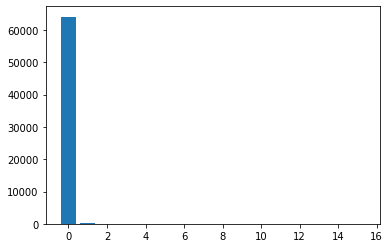

In [38]:
award_distribution = pd.Series(nx.get_node_attributes(ClimateGraph, 'total_awards_received').values())
print(f"Number of Reddit authors with at least one award: {(award_distribution > 0).sum()}")

award_distribution = Counter(award_distribution)

plt.bar(award_distribution.keys(), award_distribution.values())
plt.show()

In [39]:
OrderedDict(sorted(award_distribution.items(), key=lambda x: x[0]))

OrderedDict([(0, 64125),
             (1, 109),
             (2, 12),
             (3, 8),
             (4, 3),
             (6, 1),
             (7, 1),
             (15, 1)])

### 5) ClimateGraph - Network Evolution

Here the network evolution across time is investigated and plotted to see if there is a potential benefit of investigating the network structure from a temporal viewpoint.

In [6]:
temporal_ClimateGraph = pd.DataFrame([])

years = [2017, 2018, 2020]
for i, year in enumerate(tqdm(years)):
    
    ClimateGraph = read_json_file(DATA_DIR / f'{year}/ClimateGraph_{year}.json')
    opinion_dict = nx.get_node_attributes(ClimateGraph, 'opinion_score')
    
    nodes = ClimateGraph.number_of_nodes()
    edges = ClimateGraph.number_of_edges()
    
    mean_opinion = np.mean(list(opinion_dict.values()))
    var_opinion = np.std(list(opinion_dict.values()))
    
    temp = pd.DataFrame.from_dict({'nodes': [nodes],
                                   'edges': [edges],
                                   'mean_opinion': [mean_opinion],
                                   'var_opinion': [var_opinion],
                                   'year': year,
                                  })
    
    temporal_ClimateGraph = pd.concat([temporal_ClimateGraph, temp]).reset_index(drop=True)

# add sentiment label
temporal_ClimateGraph['opinion'] = temporal_ClimateGraph.mean_opinion.apply(lambda x: 'Pro' if x > 0.2 \
                                                                            else 'Anti' if x < -0.2 \
                                                                            else 'Neutral')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
temporal_ClimateGraph

,nodes,edges,mean_opinion,var_opinion,year,opinion
0,38415,66912,-0.054007,0.207312,2017,Neutral
1,38178,58903,-0.047296,0.212982,2018,Neutral
2,64260,95736,-0.050748,0.202096,2020,Neutral


In [ ]:
import plotly.express as px

fig = px.scatter(temporal_ClimateGraph,
                 x="year", 
                 y="mean_opinion", color="opinion",
                 size='nodes', hover_data=['edges'])
fig.show()

It is further checked, whether the authors drift in opinion scores across years. This is done with respect to preceeding year (e.g. between 2017 and 2018 or between 2019 and 2020). Since preceeding year are examined, only opinion score distributions of authors occurring in both of the two considered years are compared against each other. This provides the basis for applying a paired statistical test. The choice of statistical test was based on the Shapiro-Wilks test for normality where it was found for all years, that opinion score distributions for a year do not follow a Gaussian distribution. For this reason, the non-parametrical paired test, Wilcoxon Signed Rank-Sum test (aka. Wilcoxon paired t-test) was chosen for the statistical test. The implementation is done below and the output is printed while running.

In [146]:
year = 2017
old_author = pd.read_json(DATA_DIR / f'{year}/author_opinion_{year}.json.bz2').reset_index().rename(columns={'index':'author'})

years = [2018]
for i, year in enumerate(tqdm(years)):
    print(f"\n{'-'*50} {year-1}-{year} {'-'*50}")
    year_author = pd.read_json(DATA_DIR / f'{year}/author_opinion_{year}.json.bz2').reset_index().rename(columns={'index':'author'})
    
    combined = old_author.merge(year_author, on='author', suffixes=['_old', '_new'])
    combined = combined[['author', 'opinion_score_old', 'opinion_score_new']]
    combined.sample(10)
    
    print(f"\nNumber of overlapping authors between: {combined.__len__()}\n")
    
    print(f"Shapiro-test for normality check of opinion distribution (year = {year-1}): \n{shapiro(df_4_stats['opinion_score_old'])}")
    print(f"\nShapiro-test for normality check of opinion distribution(year = {year}): \n{shapiro(df_4_stats['opinion_score_new'])}")

    wilcox = wilcoxon(combined['opinion_score_old'], combined['opinion_score_new'])
    print(f"\nWilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): \n{wilcox}")
    print(f"\nRecurring authors changed their opinion between {year-1}-{year}? {wilcox.pvalue < 0.05} (95% confidence)")
    
    old_author = year_author

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------- 2017-2018 --------------------------------------------------

Number of overlapping authors between: 4048

Shapiro-test for normality check of opinion distribution (year = 2017): 
ShapiroResult(statistic=0.8088008165359497, pvalue=0.0)

Shapiro-test for normality check of opinion distribution(year = 2018): 
ShapiroResult(statistic=0.8116710186004639, pvalue=0.0)

Wilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): 
WilcoxonResult(statistic=1597598.0, pvalue=0.019367425036864137)

Recurring authors changed their opinion between 2017-2018? True (95% confidence)
